In [1]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from collections import deque
import numpy as np
import argparse
import cv2
import time
%matplotlib inline


# Utility Functions
functions to help you run the notebook more easily

In [2]:
def show_image(image):
    plt.imshow(image)
    plt.show()

# Load the image

In [3]:
!wget https://img-cdn.brainberries.co/wp-content/uploads/2019/05/11_Animals_That_Can_Change_Gender_2.jpg -O data/nemo_1.jpg
!wget https://fishesofaustralia.net.au/Images/Image/AmphiprionPerculaDH.jpg -O data/nemo_2.jpg

--2021-10-30 12:44:29--  https://img-cdn.brainberries.co/wp-content/uploads/2019/05/11_Animals_That_Can_Change_Gender_2.jpg
Resolving img-cdn.brainberries.co (img-cdn.brainberries.co)... 104.18.19.89, 104.18.18.89, 2606:4700::6812:1359, ...
Connecting to img-cdn.brainberries.co (img-cdn.brainberries.co)|104.18.19.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82959 (81K) [image/jpeg]
Saving to: ‘data/nemo_1.jpg’

data/nemo_1.jpg     100%[===================>]  81.01K  --.-KB/s    in 0.07s   

2021-10-30 12:44:29 (1.09 MB/s) - ‘data/nemo_1.jpg’ saved [82959/82959]

--2021-10-30 12:44:29--  https://fishesofaustralia.net.au/Images/Image/AmphiprionPerculaDH.jpg
Resolving fishesofaustralia.net.au (fishesofaustralia.net.au)... 104.21.61.231, 172.67.216.12, 2606:4700:3031::ac43:d80c, ...
Connecting to fishesofaustralia.net.au (fishesofaustralia.net.au)|104.21.61.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65456 (64K) [image/jpeg]

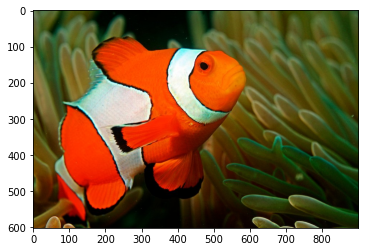

In [3]:
# load and show image 
nemo = cv2.imread('data/nemo_1.jpg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB) #why this line ?
show_image(nemo)

# Visualize Image
## In RGB

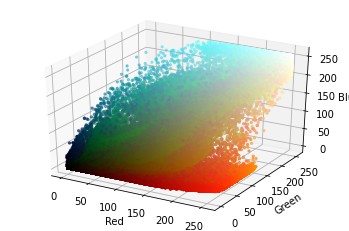

In [4]:
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [5]:
# convert color to hsv
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)


## In HSV

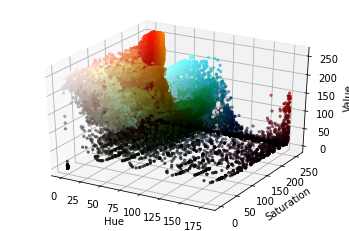

In [6]:
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

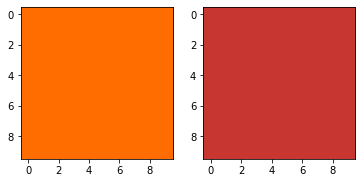

In [7]:
# pick selected color ranges and show them
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

from matplotlib.colors import hsv_to_rgb
lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

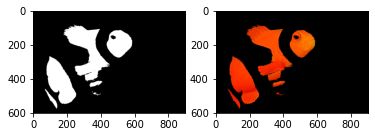

In [8]:
# filter selected range
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

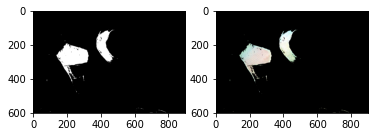

In [9]:
# get the whites too
light_white = (0, 0, 200)
dark_white = (145, 60, 255)






















mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

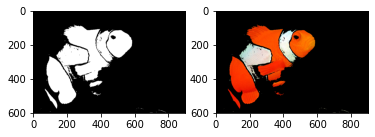

In [10]:
# add the masks
final_mask = mask + mask_white

final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
\
plt.show()

# Does the segmentation generalize ?

In [11]:
def segment_fish(image):
    ''' Attempts to segment the clownfish out of the provided image '''

    # Convert the image into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Set the orange range
    light_orange = (1, 190, 200)
    dark_orange = (18, 255, 255)

    # Apply the orange mask 
    mask = cv2.inRange(hsv_image, light_orange, dark_orange)

    # Set a white range
    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)

    # Apply the white mask
    mask_white = cv2.inRange(hsv_image, light_white, dark_white)

    # Combine the two masks
    final_mask = mask + mask_white
    result = cv2.bitwise_and(image, image, mask=final_mask)

    # Clean up the segmentation using a blur
    blur = cv2.GaussianBlur(result, (7, 7), 0)
    return blur

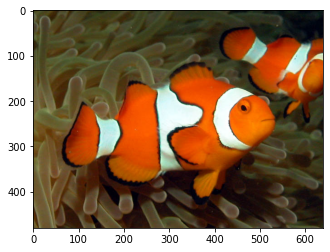

In [12]:
nemo2 = cv2.cvtColor(cv2.imread("data/nemo_2.jpg"), cv2.COLOR_BGR2RGB)
show_image(nemo2)

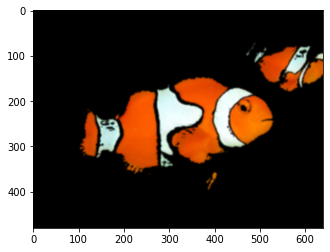

In [13]:
segmented = segment_fish(nemo2)
show_image(segmented)

In [14]:
cap = cv2.VideoCapture(0)

while(1):

    # Take each frame
    _, frame = cap.read()

    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)

    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)
    k = cv2.waitKey(5) & 0xFF
    if k == ord("q"):
        break
cv2.destroyAllWindows()


In [16]:
# TODO: add advanced color tracking from py image search        


TypeError: Expected Ptr<cv::UMat> for argument 'src'